# Text classification with LR, NB and SVMs

Document/Text classification is one of the important and typical task in supervised machine learning (ML), with many applications such as spam filtering, email routing, sentiment analysis. 

In this worksheet we will go through a text based sentiment analysis using some linear and nonlinear models. We will learn how to extract features from text. 

We also peform grid search and randomized search for tuning the hyperparameters for support vector machines. Randomised search is often more efficient (requires much less run time) than grid search when it comes to hyperparameter tuning search, see [the comparison](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)



Here's the documentation for the SVM in sklearn:
- https://scikit-learn.org/stable/modules/svm.html

Please familarise yourself with the idea of examining documentation without prompt as you need to get used to it for your assignment and future data science work.

This worksheet was adapted from Eugen Anghel's [python notebook](https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness/data)

# Sentiment analysis using Amazon review dataset

We will be reviewing a Kaggle featured dataset of over 500k Amazon customer food reviews, provided by Stanford Network Analysis Project. Our aim is to develop models for predicting whether a customer review message is positive or negative. We will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

We will go through several key steps for this machine learning task:

- Extracting features from text files, such as **bag of words** and **Term Frequency - Inverse Document Frequency** (TF-IDF).
- Splitting data into **training/validation/testing**
- Fitting Naive Bayes, logistic regression, and SVM models
- Evaluating model performance using **ROC analysis**
- Selecting hyperparameters and models using Scikit-learn pipeline and **grid search** based on validation set
- Making prediction on the test set, and evaluate
- Examining important features for the prediction


In [66]:
%matplotlib inline

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



## Loading the data
In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary. 
For more detailed description of the data, please see: 
http://snap.stanford.edu/data/web-FineFoods.html

As we only want to get the global sentiment of the review (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of (e.g.) 0.2

Let's first check whether we have the dataset available:

In [61]:
# For google colab user only. You can mount your google drive, and use the folder
# as in any virtual machine. 
# You can also explore your good drive by clicking [folder icon] in the menu 
#  to left of the colab notebook
from google.colab import drive
drive.mount('/content/gdrive')
!ls

ModuleNotFoundError: No module named 'google'

In [67]:
# Change the directory appropriate to you
dir = "./"
messages = pd.read_csv(os.path.join(dir, "review10k.csv"), sep=",")
#messages = pd.read_csv("/content/gdrive/MyDrive/CSM6420/data/review10k.csv", sep=',')

messages.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [68]:
# Only pick columns of interest, and rename a few columns
messages = messages[["Score", "Summary","HelpfulnessNumerator","HelpfulnessDenominator"]]
messages = messages.rename(columns={"HelpfulnessNumerator": "VotesHelpful", "HelpfulnessDenominator": "VotesTotal"})


In [4]:
messages.describe(include='all')

,Score,Summary,VotesHelpful,VotesTotal
count,10000.000000,10000,10000.000000,10000.000000
unique,NaN,8526,NaN,NaN
top,NaN,Delicious,NaN,NaN
freq,NaN,43,NaN,NaN
mean,4.134500,NaN,1.573500,2.014900
std,1.327172,NaN,5.230634,5.807551
min,1.000000,NaN,0.000000,0.000000
25%,4.000000,NaN,0.000000,0.000000
50%,5.000000,NaN,0.000000,1.000000
75%,5.000000,NaN,2.000000,2.000000


(array([ 932.,  590.,  862., 1433., 6183.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

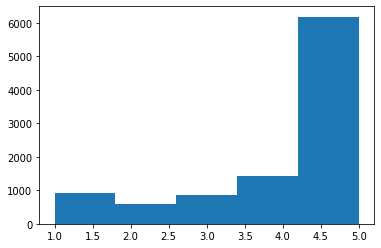

In [69]:
# Your code here: 
# Check the distribution of the score (histogram)
plt.hist(messages.Score,bins=5)

10000


(array([7459., 1470.,  272.,  304.,  102.,  128.,   65.,   27.,   38.,
          22.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

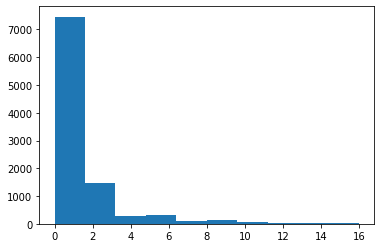

In [70]:
# You code here:
# Check the distribution of VotesHelpful. 
# Hint: Some data transformation might be needed 
print(messages.VotesHelpful.count())

plt.hist(messages.VotesHelpful.sort_values()[0:9887])

Now let's select only what's of interest to us:

(array([11.,  8.,  8.,  9.,  4.,  9.,  7.,  3.,  5.,  3.,  6.,  0.,  3.,
         2.,  1.,  2.,  0.,  0.,  1.,  1.,  3.,  1.,  3.,  0.,  1.,  0.,
         1.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

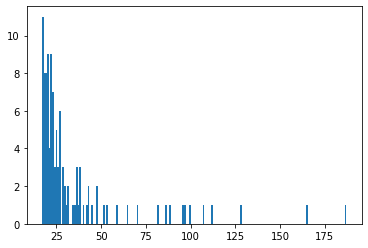

In [7]:
plt.hist(messages.VotesHelpful.sort_values()[9887:],bins=180)[:,1]

In [71]:
messages = messages[messages.Score!=3]

Let's see what we've got:

In [9]:
messages.head(10)

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0
5,4,Nice Taffy,0,0
6,5,Great! Just as good as the expensive brands!,0,0
7,5,"Wonderful, tasty taffy",0,0
8,5,Yay Barley,1,1
9,5,Healthy Dog Food,0,0


Let's add the **Sentiment** column that turns the numeric score into either *positive*=1 or *negative* =0.

In [88]:
messages["Sentiment"] = messages["Score"].apply(lambda x: 1 if x > 3 else 0)
messages["Sentiment"] = messages["Sentiment"]
messages.head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Summary_Clean
0,5,Good Quality Dog Food,1,1,1,good quality dog food
1,1,Not as Advertised,0,0,0,not as advertised
2,4,"""Delight"" says it all",1,1,1,delight says it all
3,2,Cough Medicine,3,3,0,cough medicine
4,5,Great taffy,0,0,1,great taffy
5,4,Nice Taffy,0,0,1,nice taffy
6,5,Great! Just as good as the expensive brands!,0,0,1,great just as good as the expensive brands
7,5,"Wonderful, tasty taffy",0,0,1,wonderful tasty taffy
8,5,Yay Barley,1,1,1,yay barley
9,5,Healthy Dog Food,0,0,1,healthy dog food


(array([1522., 7616.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

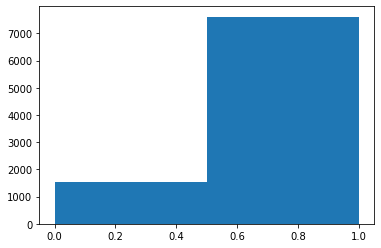

In [89]:
# Your code here:
# Check the distribution of Sentifment and Usefulness
plt.hist(messages.Sentiment,bins=2)
# plt.hist(messages.Usefulness)

Let's have a look at some 5s:

In [74]:
messages[messages.Score == 5].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment
0,5,Good Quality Dog Food,1,1,1
4,5,Great taffy,0,0,1
6,5,Great! Just as good as the expensive brands!,0,0,1
7,5,"Wonderful, tasty taffy",0,0,1
8,5,Yay Barley,1,1,1
9,5,Healthy Dog Food,0,0,1
10,5,The Best Hot Sauce in the World,1,1,1
11,5,"My cats LOVE this ""diet"" food better than thei...",4,4,1
14,5,Strawberry Twizzlers - Yummy,4,5,1
15,5,"Lots of twizzlers, just what you expect.",4,5,1


And some 1s as well:

In [75]:
messages[messages.Score == 1].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment
1,1,Not as Advertised,0,0,0
12,1,My Cats Are Not Fans of the New Food,1,1,0
26,1,Nasty No flavor,0,1,0
50,1,Don't like it,0,7,0
62,1,stale product.,2,2,0
73,1,Warning! WARNING! -ALCOHOL SUGARS!,0,1,0
75,1,No Tea Flavor,0,0,0
99,1,Bad,0,1,0
153,1,Rip off Price,1,1,0
164,1,Tasteless but low calorie,0,4,0


## Extracting features from text data

Text data are usually series of ordered words, which need to be converted to numerical features before feeding to machine learning algorithms. 

- **Bag of words**: Bag of words model is one popular representation for text, in which we segment each text file (one English review mesage separated by space in this case) into words, and count # of times each word occurs in each document and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature (descriptive feature).

- **TF** (Term Frequency): Just counting the number of words in each document has 1 issue: it will give more weights to longer documents than shorter documents. To avoid this, we can use frequency, i.e. TF = #count of word / #Total words, in each document.

- **TF-IDF** (Term Frequency times Inverse Document Frequency): Finally, we can even reduce the weight of more common words like (the, is, an etc.) which occurs in most document. This is called TF-IDF i.e Term Frequency times inverse document frequency, where inverse document frequency = log(#Total docs / #count of doc containing word). See: https://en.wikipedia.org/wiki/Tf%E2%80%93idf 

Scikit-learn has a high level component which will create such feature vectors for us ‘CountVectorizer’ and 'TfidfTransformer'. 
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

See more here: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [90]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re #regular expression module
import string
#import nltk # natural languaage toolkit (https://www.nltk.org/)

cleanup_re = re.compile('[^a-z]+') #string that contains lowcase alphabets only
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

In [83]:
# Your code here:
# Check the first 10 records of Summary and Summary_Clean (to understand the effect of cleanup)
messages[["Summary","Summary_Clean"]][0:10]

,Summary,Summary_Clean
0,Good Quality Dog Food,good quality dog food
1,Not as Advertised,not as advertised
2,"""Delight"" says it all",delight says it all
3,Cough Medicine,cough medicine
4,Great taffy,great taffy
5,Nice Taffy,nice taffy
6,Great! Just as good as the expensive brands!,great just as good as the expensive brands
7,"Wonderful, tasty taffy",wonderful tasty taffy
8,Yay Barley,yay barley
9,Healthy Dog Food,healthy dog food


In [84]:
# Getting the indices for splitting data into training, and test set 
#train, test = train_test_split(messages, test_size=0.2)
# Set random seed to ensure result reproducibility
# Here train, test are the indices for the examples
random_seed = 12345
train, test = train_test_split(np.arange(messages.shape[0]), test_size=0.2, random_state= random_seed)
print("%d items in training set, %d in test set" % (len(train), len(test)))

7310 items in training set, 1828 in test set


In [92]:
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(messages.iloc[train]["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(messages.iloc[test]["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

y_train = messages.iloc[train]["Sentiment"]
y_test = messages.iloc[test]["Sentiment"]

# Initialise the dictionary to store prediction results
prediction = dict() 

In [93]:
# Checking dataset dimensionality 
print(X_train_counts.shape)
print(X_train_tfidf.shape)
print(X_test_counts.shape)
print(X_test_tfidf.shape)

# Get the indices of nonzero elements in the sparse matrix
rows, cols = X_train_tfidf.nonzero()
# Print the first 5 nonzero elements
print(X_train_tfidf[rows[0:5], cols[0:5]]) 

(7310, 37270)
(7310, 37270)
(1828, 37270)
(1828, 37270)
[[0.25 0.25 0.18 0.25 0.25]]


## Let's get fancy with WordClouds!

Note: just in case of missing library 'worcloud' , run the following to install it. Or otherwise you don't have to run it yourself, just look at the existing figures. 

$ conda install -c conda-forge wordcloud 

or 

$ pip install wordcloud

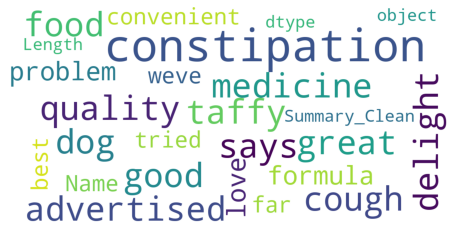

In [95]:
from wordcloud import WordCloud

mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

We can also view wordclouds for only positive or only negative entries:

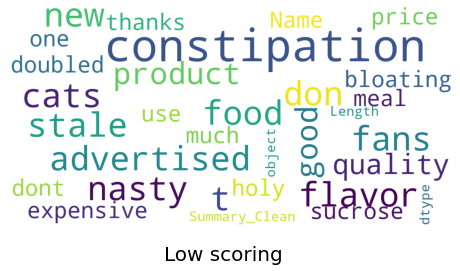

In [96]:
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Low scoring")

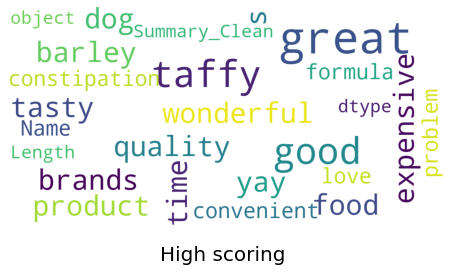

In [21]:
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "High scoring")

## Applying Multinomial Naïve Bayes

Note: to computer AUC, we need to return a continous score or a probability output using e.g. predict_proba, which will return often multiple columnns for different classes. 

In [97]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(X_train_tfidf, y_train)

prediction['Multinomial'] = nb.predict_proba(X_test_tfidf)[:,1]

## Applying Logistic regression

In [98]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()#(C=1e3)
lr=logreg.fit(X_train_tfidf[0:1000], y_train[0:1000])
prediction['Logistic'] = logreg.predict_proba(X_test_tfidf)[:,1]
prediction['Logistic2'] = logreg.predict(X_test_tfidf)

## Applying Support Vector Machines

To speed up the experiments here, you can start with just a [linear kernel](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Example of grid search for fine tuning RBF kernel parameter can be found [here](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py). 

Note that: when peform grid search, the it's important to cover a broad enough range for some parameters (such as C and gamma for SVMs), oftne log space will be used instead of linear space: e.g. np.logspace(-3, -2, 3)

### Question 
Do you need to normalise or scale the input data in this case?

### Exercise 
Use grid search and [randomizedSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to optimise hyperparameters: gamma and C for RBF kernel, or C for linear kernel. You may compare the time used the performance and time used between the two methods. 

Better to start with a few values in the grid to test the code. And the grid can be refined further. 

**Note**: Randomised search is usually works much more efficiently than the grid search e


In [25]:
from sklearn.svm import SVC
from time import time

C_range = np.logspace(-3, -2, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(C=C_range,gamma=gamma_range)
# Your code here
start = time()
grid = GridSearchCV(SVC(), param_grid,verbose=5)
grid.fit(X_train_tfidf, y_train)

print("The best parameters are %s with a score of %0.2f"
     % (grid.best_params_, grid.best_score_))
print("GridSearch took %.2f seconds"
      " parameter settings." % ((time() - start)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...........................C=0.001, gamma=1e-09; total time=   0.8s
[CV 2/5] END ...........................C=0.001, gamma=1e-09; total time=   0.8s
[CV 3/5] END ...........................C=0.001, gamma=1e-09; total time=   0.8s
[CV 4/5] END ...........................C=0.001, gamma=1e-09; total time=   0.8s
[CV 5/5] END ...........................C=0.001, gamma=1e-09; total time=   0.8s
[CV 1/5] END ...........................C=0.001, gamma=1e-06; total time=   0.9s
[CV 2/5] END ...........................C=0.001, gamma=1e-06; total time=   0.9s
[CV 3/5] END ...........................C=0.001, gamma=1e-06; total time=   0.9s
[CV 4/5] END ...........................C=0.001, gamma=1e-06; total time=   0.8s
[CV 5/5] END ...........................C=0.001, gamma=1e-06; total time=   0.8s
[CV 1/5] END ...........................C=0.001, gamma=0.001; total time=   0.9s
[CV 2/5] END ...........................C=0.001

In [26]:
from sklearn.svm import SVC
C_range = np.logspace(-3, -2, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(C=C_range,gamma=gamma_range)
# Your code here
start = time()

clf = RandomizedSearchCV(SVC(), param_grid, random_state=0,verbose=10)
clf.fit(X_train_tfidf, y_train)

print("The best parameters are %s with a score of %0.2f"
     % (grid.best_params_, grid.best_score_))
print("RandomizedSearchCV took %.2f seconds"
      " parameter settings." % ((time() - start)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.0021544346900318843, gamma=0.017301957388458907........
[CV 1/5; 1/10] END C=0.0021544346900318843, gamma=0.017301957388458907; total time=   0.9s
[CV 2/5; 1/10] START C=0.0021544346900318843, gamma=0.017301957388458907........
[CV 2/5; 1/10] END C=0.0021544346900318843, gamma=0.017301957388458907; total time=   0.9s
[CV 3/5; 1/10] START C=0.0021544346900318843, gamma=0.017301957388458907........
[CV 3/5; 1/10] END C=0.0021544346900318843, gamma=0.017301957388458907; total time=   0.9s
[CV 4/5; 1/10] START C=0.0021544346900318843, gamma=0.017301957388458907........
[CV 4/5; 1/10] END C=0.0021544346900318843, gamma=0.017301957388458907; total time=   0.9s
[CV 5/5; 1/10] START C=0.0021544346900318843, gamma=0.017301957388458907........
[CV 5/5; 1/10] END C=0.0021544346900318843, gamma=0.017301957388458907; total time=   0.9s
[CV 1/5; 2/10] START C=0.0016681005372000592, gamma=231.7818180600885..........

In [102]:
from sklearn import tree 
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train_tfidf, y_train)
prediction['dtree'] = dtree.predict_proba(X_test_tfidf)[:,1]


In [103]:
# Train and test the SVM classifier with the 'best' parameter chosen from CV
# Hint: use all training example this time to train the model
# Your code here 
#
svm = SVC(C=0.001,gamma=1e-09,probability=True)
svm = svm.fit(X_train_tfidf, y_train)

prediction['svm'] = svm.predict_proba(X_test_tfidf)[:,1]


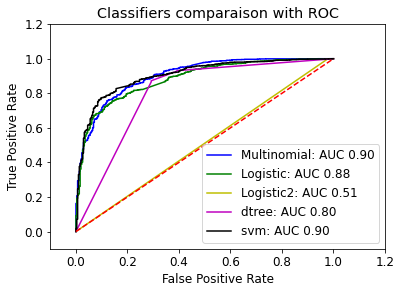

In [104]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Question:

Based on the ROC curves and AUC value, which method provides the best results? 

Let's remember what Precision and Recall are (more here https://en.wikipedia.org/wiki/Precision_and_recall)

In [ ]:
SVM seems to be the best

![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

In [34]:
print(prediction['Logistic'])
print(metrics.classification_report(y_test, prediction['Logistic2'], target_names = ["positive", "negative"]))

[0.77129408 0.89862588 0.86987237 ... 0.86623588 0.81078555 0.58082811]
              precision    recall  f1-score   support

    positive       0.78      0.02      0.04       308
    negative       0.83      1.00      0.91      1520

    accuracy                           0.83      1828
   macro avg       0.81      0.51      0.48      1828
weighted avg       0.82      0.83      0.76      1828



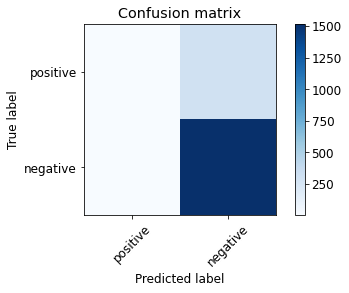

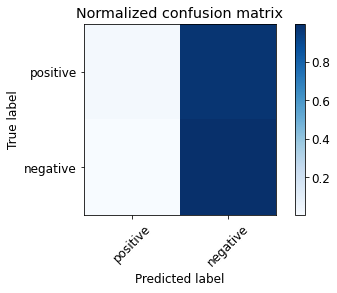

In [36]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic2'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

Let's also have a look at what the best & words are by looking at the coefficients:

In [38]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, lr.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
22276,not,-2.976552
2320,awful,-1.583872
4019,bitter,-1.485268
8524,disappointing,-1.350757
16012,horrible,-1.246291
...,...,...
37140,yummy,1.021133
19293,love,1.070827
7995,delicious,1.167189
3059,best,1.536359


In [40]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result, prob[0], prob[1]))

test_sample(logreg, "The food was delicious, it smelled great and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. The smell was so bad that it literally made me sick.")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as 1: negative prob 0.118484, positive prob 0.881516
Sample estimated as 1: negative prob 0.320427, positive prob 0.679573
Sample estimated as 1: negative prob 0.207292, positive prob 0.792708


There are also some weird predictions:

In [41]:
test_sample(logreg, "The smell reminded me of ammonia")

Sample estimated as 1: negative prob 0.252263, positive prob 0.747737


### Exercise
1. Try out some feature selection methods, can you improve the model performance for logistic regression?




2. Try out at least another classification method on this problem using sklearn, and compare the performance.



In [106]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k=100).fit_transform(X_train_tfidf, y_train)
X_test = SelectKBest(chi2, k=100).fit_transform(X_test_tfidf, y_test)

X_new.shape
logreg = LogisticRegression()#(C=1e3)
lr=logreg.fit(X_new[0:1000], y_train[0:1000])
prediction['Logistic'] = logreg.predict_proba(X_test)[:,1]
prediction['Logistic2'] = logreg.predict(X_test)
lr=logreg.fit(X_test_tfidf[0:1000], y_train[0:1000])
prediction['Logistic3'] = logreg.predict(X_test_tfidf)

print(metrics.classification_report(y_test, prediction['Logistic2'], target_names = ["positive", "negative"]))

print(metrics.classification_report(y_test, prediction['Logistic3'], target_names = ["positive", "negative"]))


              precision    recall  f1-score   support

    positive       1.00      0.02      0.03       308
    negative       0.83      1.00      0.91      1520

    accuracy                           0.83      1828
   macro avg       0.92      0.51      0.47      1828
weighted avg       0.86      0.83      0.76      1828

              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       308
    negative       0.83      1.00      0.91      1520

    accuracy                           0.83      1828
   macro avg       0.42      0.50      0.45      1828
weighted avg       0.69      0.83      0.76      1828



## Additional tutorial on Gradient Descent for Linear Regression if you are interested in looking at a simple GD implementation 
## Stochastic Gradient Descent for Regression

It would be useful to go through the following tutorial:

https://machinelearningmastery.com/implement-linear-regression-stochastic-gradient-descent-scratch-python/

The wine dataset can be loaded from sklearn
- from sklearn.datasets import load_wine

- Once you have completed the tutorial, extend the solution to use cross validation.
- Modify function coefficients_sgd so that it can take a parameter ‘batchsize’ to allow coefficient (or weight ) update in a mini-batch way. Test your code.